# Universal Portfolio(UP) in zipline with CSV data
Universal portfolio is implemented.  
If we obtain weights of portfolio components, we can apply trading.  
The codes are given in OLMAR example code.  
You can change trsaction cost yourself.

## References
I borrowed codes for universal portfolio and zipline example codes from  
https://github.com/andrewcharlesjones/universal_portfolios/blob/master/universal_portfolio.ipynb  
https://github.com/shlomikushchi/zipline-trader/blob/master/zipline/examples/olmar.py

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import pandas as pd

import zipline
from zipline.data import bundles
from zipline.data.bundles import ingest, load, register

from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.data.data_portal import DataPortal

from zipline.finance import commission, slippage
from zipline.utils.calendars import get_calendar
from zipline import run_algorithm

In [3]:
home_zipline = 'PATH'
os.environ['ZIPLINE_ROOT'] = os.path.join(home_zipline, '.zipline')
os.environ['CSVDIR'] = 'CSV PATH'

## note 
* DELL do not have data before 2016-7?

## Preparation
Load data and set necessaries

In [9]:
bundle_name = 'csvdir'
bundle_data = bundles.load(bundle_name)
STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']
# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# time should be a business datetime
start_date = pd.Timestamp('2016-09-20', tz='utc')
end_date = pd.Timestamp('2021-03-01', tz='utc')

## Definition of strategy

### UP utilities

In [10]:
# gets the total return for a given portfolio b
def portfolio_wealth(b, stock_data):
    return np.prod(np.dot(b, stock_data))

# function for retrieving all possible portfolios at a certain level of granularity
def binnings(n, k, cache={}):
    """
    makes bins of all possibilities of allocations
    ex. [1,0,0,0,...], [0.9, 0.1, 0, ...], ...
    """
    if n == 0:
        return np.zeros((1, k))
    if k == 0:
        return np.empty((0, 0))
    args = (n, k)
    if args in cache:
        return cache[args]
    a = binnings(n - 1, k, cache)
    a1 = a + (np.arange(k) == 0)
    b = binnings(n, k - 1, cache)
    b1 = np.hstack((np.zeros((b.shape[0], 1)), b))
    result = np.vstack((a1, b1))
    cache[args] = result
    return result

### UP trading

In [71]:
def initialize(algo):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.init = True
    algo.days = 1
    
    algo.set_commission(commission.PerShare(cost=0, 
                                            min_trade_cost=1.0))
    algo.set_slippage(slippage.VolumeShareSlippage())


def handle_data(algo, data):
    history = data.history(algo.sids, 'close', algo.days, '1d')
    returns = history.pct_change().fillna(0).to_numpy() + 1.0
    returns = returns.transpose()
    
    rets = [portfolio_wealth(port1, returns) 
            for port1 in list(all_portfolios)]
    weights = np.dot(rets, all_portfolios)
    weightsb = weights/np.sum(rets)

    rebalance_portfolio(algo, data, weightsb)

    # update portfolio
    algo.b_t = weightsb
    algo.days += 1
    
    
def rebalance_portfolio(algo, data, desired_port):
    """
    Execute trading. Obtained from OLMAR example
    if a weight of portfolio elements, parameter desired_port, 
    is given, it gives order amount and execute it
    """
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data.current(sid, "price")

    desired_amount = np.round(desired_port * positions_value / prices)
    
    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])

## Run UP strategy

In [22]:
# set UniversalPortfolio settings
# all_portfolios has all constant weight portfolios
allocation_granularity = 10
num_stocks = len(STOCKS)
all_portfolio_allocations = binnings(allocation_granularity, num_stocks)
row_sums = all_portfolio_allocations.sum(axis=1)
all_portfolios = all_portfolio_allocations / row_sums[:, np.newaxis]

In [73]:
# check
all_portfolios[:3]

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.9, 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0.9, 0. , 0.1, 0. , 0. , 0. , 0. ]])

In [24]:
import pandas_datareader.data as yahoo_reader
def get_benchmark(symbol=None, start=None, end=None):
    bm = yahoo_reader.DataReader(symbol,
                                 'yahoo',
                                 pd.Timestamp(start),
                                 pd.Timestamp(end))['Close']
    bm.index = bm.index.tz_localize('UTC')
    return bm.pct_change(periods=1).fillna(0)

def before_trading_start(context, data):
    pass

In [25]:
benchmark = get_benchmark(symbol="SPY",
                          start=start_date.date().isoformat(),
                          end=end_date.date().isoformat())

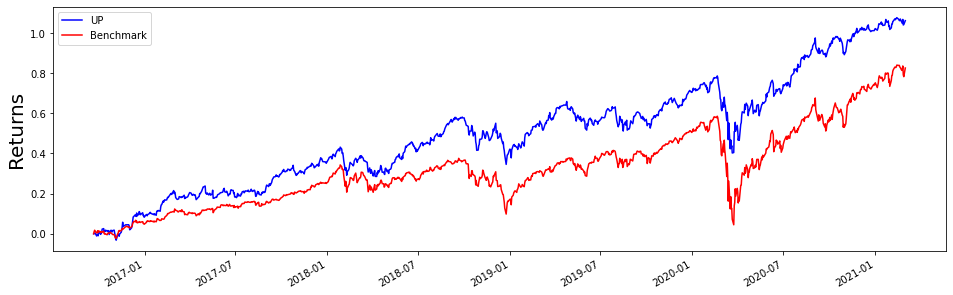

In [72]:
r = run_algorithm(start=start_date,
                      end=end_date,
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      benchmark_returns=benchmark,
                      bundle=bundle_name,
                      broker=None,
                      state_filename="./demo.state",
                      trading_calendar=trading_calendar,
                      before_trading_start=before_trading_start,
                      #                   analyze=analyze,
                      data_frequency='daily'
                      )
fig, axes = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
r.algorithm_period_return.plot(color='blue')
r.benchmark_period_return.plot(color='red')


plt.legend(['UP', 'Benchmark'])
plt.ylabel("Returns", color='black', size=20)
plt.show()